## 1. Reflection 개념 이해하기

Reflection: LLM이 선택한 행동의 품질을 평가하기 위해 과거 단계를 관찰하도록 유도하는 과정으로, LLM의 행동에 대해 다시 계획을 세우거나, 평가와 같은 후속 작업에 사용

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

### Stpe 1. Genration LLM

In [ ]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 5단락 에세이를 훌륭하게 작성하는 에세이 도우미입니다."
            "사용자의 요청에 따라 최고의 에세이를 작성하세요."
            "사용자가 피드백을 제공할 경우, 이전 시도에서 개선된 수정본을 작성해 응답하세요."
        ),
        MessagesPlaceholder(variable_name="messages")    # messages 라는 변수로 사용자 입력이 들어가게 됨
    ]
)

llm = ChatOpenAI(model="gpt-4o")

generate = prompt | llm

In [ ]:
essay = ""
request = HumanMessage(
    content="AI Agent의 중요성에 대한 에세이를 작성해주세요."
)
# request가 messages 키의 밸류로 들어감
# 아래의 stream은 앞서 basic 설명한 langgraph의 invoke나 stream과는 다르고, 
# chat gpt 와 같은 llm 모델들이 한번에 응답을 뱉어주지 않고, 토큰별 내용을 stream 
for chunk in generate.stream({"messages": {request}}):
    print(chunk.content, end="")
    essay += chunk.content

### Stpe 2. Reflection LLM

In [ ]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 에세이를 채점하는 교사입니다. 사용자가 제출한 에세이에 대한 비평과 개선 사항을 작성하세요."
            "글의 길이, 깊이, 문제 등을 포함해 구체적인 개선 요청을 제공하세요."
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)
reflect = reflection_prompt | llm

In [ ]:
reflection = ""
# 리스트로 묶어 두 가지(리포트 작성해달라는 요청과, 생성된 essay)의 HumanMessage를 담아준 것 참고
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

피드백 내용 반영하여 재생성

In [ ]:
# 위에서 generate chqin은 피드백이 있을 경우 보고서 재생성을 하도록 되어있음
for chunk in generate.stream(
    # 리포트를 생성해달라는 요청, ai가 만든 에세이, ai의 피드배을 넣어줌
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

### Stpe 3. Graph로 Reflection 구현하기

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]

- Generate 노드

In [ ]:
# 앞에서 만든 generate chain 사용
# messages 업데이트를 통해 가장 최초의 에세이 생성 요청 및 계속된 피드백도 갖고있게 됨
def generation_node(state: State) -> State:
    return {"messages": [generate.invoke(state["messages"])]}

In [ ]:
def reflection_node(state: State) -> State:
    cls_map = {"ai": AIMessage, "human": HumanMessage}

    # 첫 번째 사용자 요청 + 생성메시지 (reflection_node's input)
    # 첫 번째 사용자 요청 + 생성메시지 + 피드백메시지 (generation_node's input)
    # 첫 번째 사용자 요청 + 생성메시지 + 피드백메시지 + 수정된 생성메세지 (reflection_node's input)
    # 첫 번째 사용자 요청 + 생성메시지 + 피드백메시지 + 수정된 생성메세지 + 피드백 메세지 (generation_node's input)
    # ...

    # 첫번 째 사용자의 요청 + 첫 번째 메세지 이후의 모든 메세지
    # mapping dictionary를 사용하여 ai 메세지인지 human 메세지인지 구분하여 들어가도록 함
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    # 뒤에서 두 번째 까지만 입력받고 싶다면 아래와 같이
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][-2:]
    ]
    res = reflect.invoke(translated)

    return {"messages": [HumanMessage(content=res.content)]}

In [ ]:
# 위의 cls_map 동작 확인
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
a = {"ai": AIMessage, "human": HumanMessage}
a["human"](content="hi")
print(a)
print(a["human"])

{'ai': <class 'langchain_core.messages.ai.AIMessage'>, 'human': <class 'langchain_core.messages.human.HumanMessage'>}
<class 'langchain_core.messages.human.HumanMessage'>


In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate", generation_node)
graph_builder.add_node("reflect", reflection_node)
graph_builder.add_edge(START, "generate")

- 반복 횟수 제한

In [ ]:
def should_continue(state: State):
    if len(state["messages"]) > 6:
        return END
    return "reflect"

graph_builder.add_conditional_edges("generate", should_continue)

In [ ]:
graph_builder.add_edge("reflect", "generate")

In [ ]:
# 메모리 추가
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
# stream을 활용하여 각 노드별 어떤 업데이트 사항이 나오는지 확인
for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="AI Agent의 중요성에 대한 에세이를 작성해주세요."
            )
        ]
    },
    config,
):
    print(event)
    print("---")

In [ ]:
state = graph.get_state(config)

In [ ]:
# state에서 messages 값만 출력하여 보기 좋게 출력
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

## 2. Reflection Agent 구현

Reflection 논문 : https://arxiv.org/abs/2303.11366

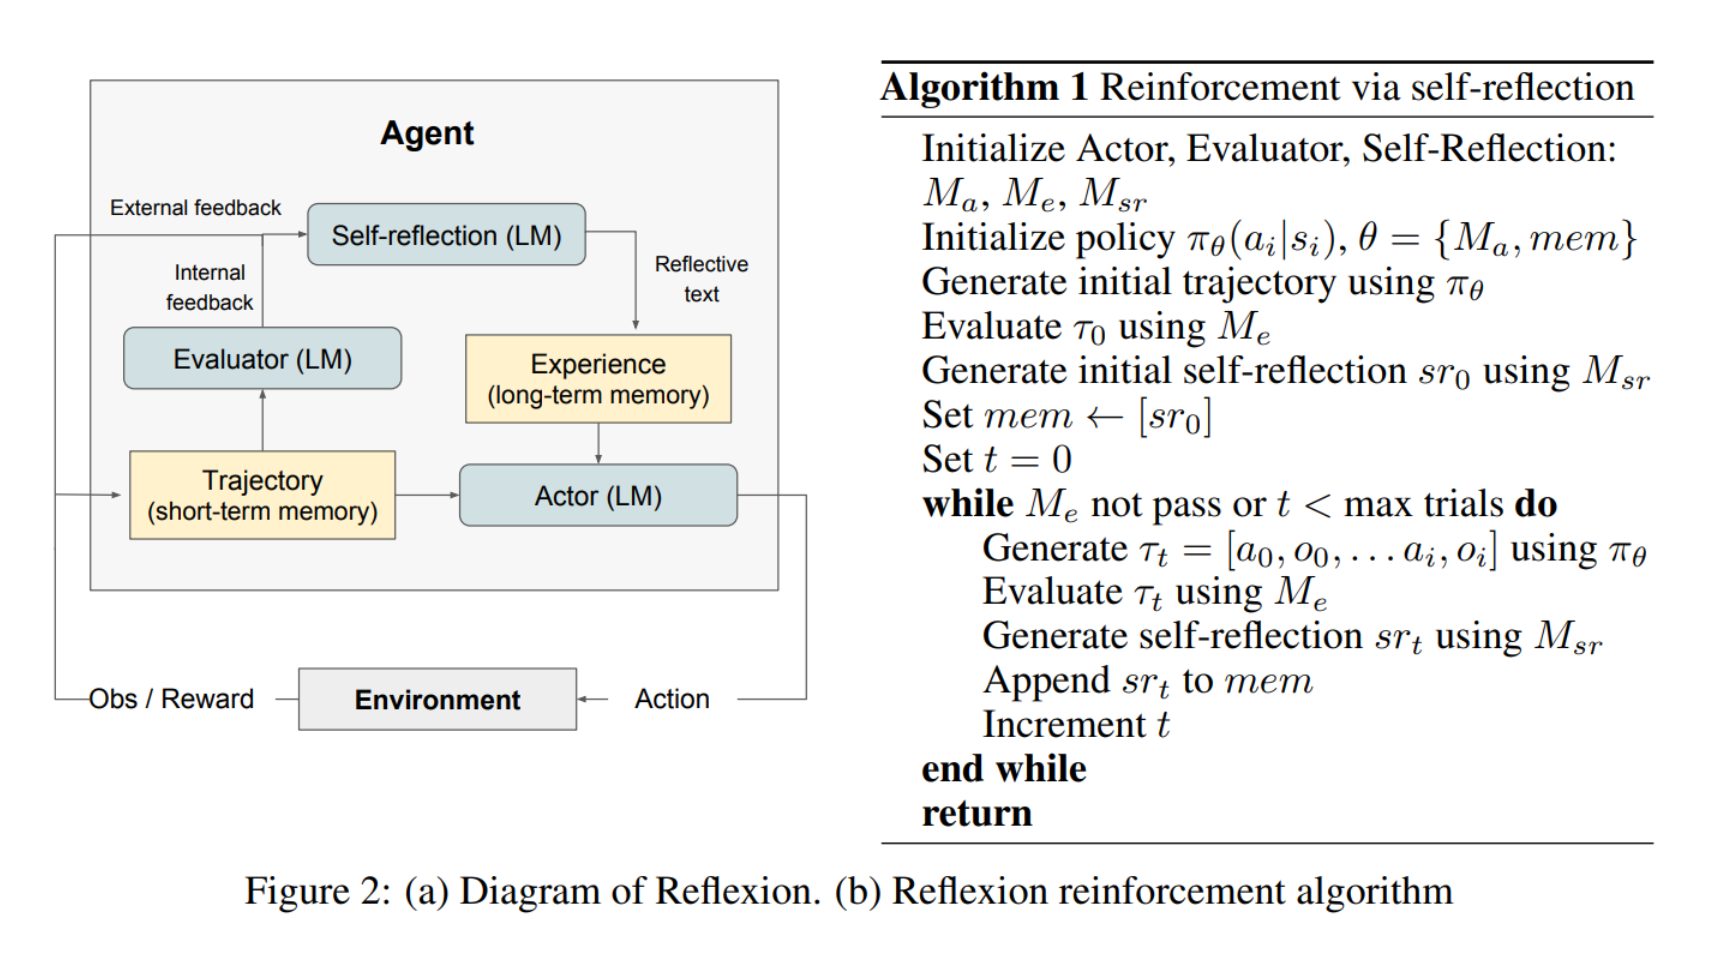

(1) 자기 반성을 하는 Agent (Actor (agent) with self-reflection)

(2) 외부 평가자 External evaluator (task-specific, e.g. code compilation steps)

(3) 자기반성 내용을 기억하는 메모리 Episodic memory that stores the reflections from (1).

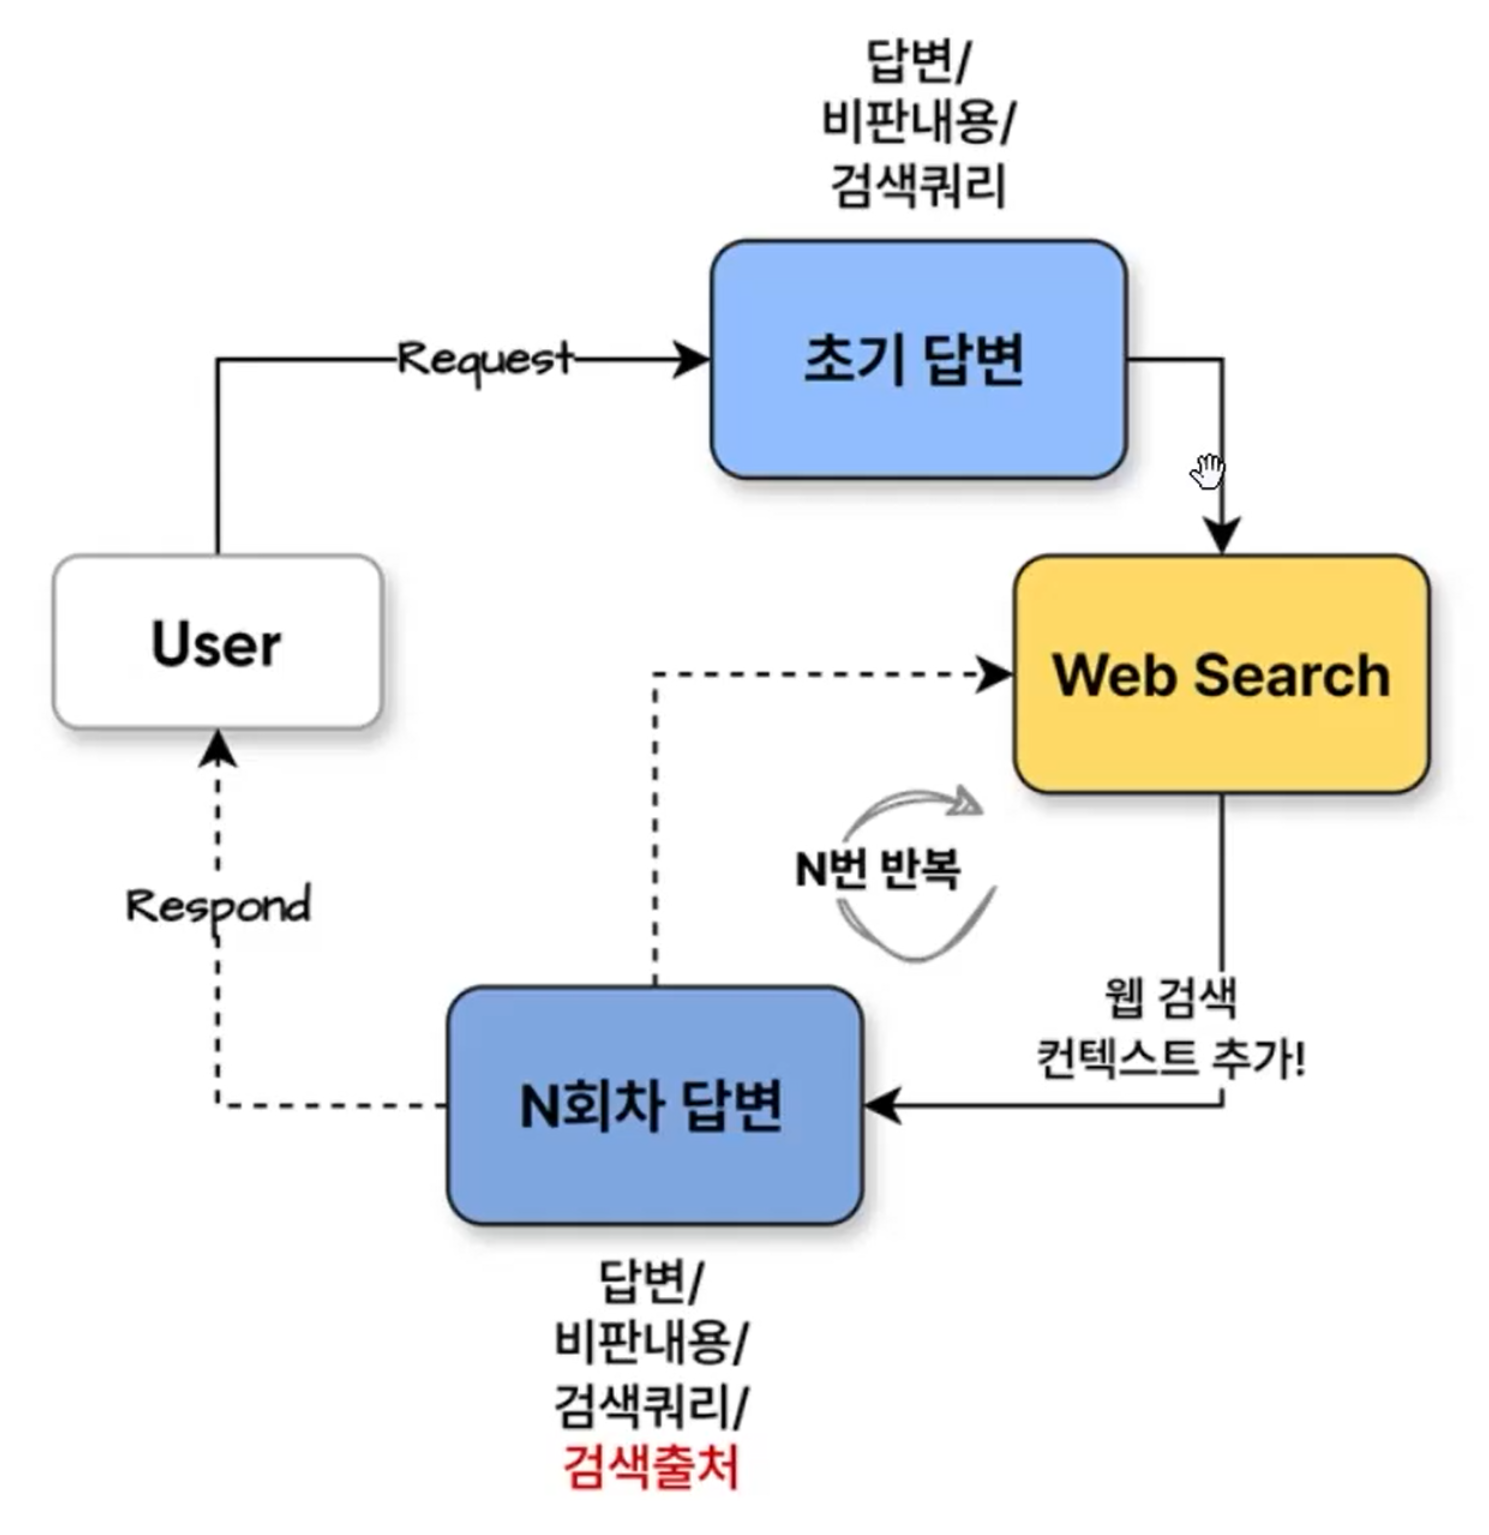

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY") # 웹 컨텍스트 추가를 위한 Tavily Search

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

#### Step 1. 필요한 데이터 클래스 정의

- Reflection - 놓친 것 / 불필요한 것

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from pydantic import BaseModel, Field

class Reflection(BaseModel):
    missing: str = Field(description="누락되거나 부족한 부분에 대한 비평")
    superfluous: str = Field(description="불필요한 부분에 대한 비평")

- AnswerQuestion - 답변 / 답변에 대한 반성 / 개선하기 위한 검색 쿼리

In [ ]:
class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="질문에 대한 10문장 이내의 자세한 답변")
    search_queries = list[str] = Field(
        description="현재 답변에 대한 비평을 해결하기 위한 추가 조사를 위한 1 ~ 3개의 웹 검색 쿼리"
    )
    reflection: Reflection = Field(description="답변에 대한 자기반성 내용")

- Responder - 구조화된 출력을 위한 답변기

In [ ]:
# 이후 runnable chain을 두 가지를 하나의 클래스의 respond 함수만 구현하여 사용할 수 있도록 
class Responder:
    def __init__(self, runnable):
        self.runnable = runnable # Chain

    def respond(self, state: dict):
        response = self.runnable.invoke(
            {"messages": state["messages"]}
        )
        return {"messages": response}

#### Step 2. 초기 답변기 만들기 (Initial responder)

- 초기 답변을 위한 Chain 생성 - 출력 스키마를 도구로 사용

In [ ]:
import datetime

# 첫 번째 지시는 동적으로 받을 수 있도록
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """당신은 전문 연구자입니다.

            1. {first_instructions}
            2. <Reflect> 생성한 답변을 다시 되돌아보고 개선할 수 있도록 비판하세요.
            3. <Recommend search queries> 답변의 질을 높이기위해 추가적으로 조사해야 할 정보에 대한 웹 검색 쿼리를 추천하세요.
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<Reflect> 사용자 원래 질문과 지금까지의 행동을 되돌아보세요."
        )
    ]
)

# 프롬프트에 llm 연결
# AnswerQuestion과 같이 도구가 아닌 데이터 스키마를 tool로 부여해주면, llm이 응답을 데이터 스키마에 맞춰 반환하게 할 수 있음
# tool_choince any를 선택하면 제공된 툴중 하나를 반드시 사용. 도구로 하나만 부여했기 때문에 반드시 실행하기 위해 적용함.
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="질문에 대한 10문장 이내의 자세한 답변을 제공해주세요.", # 초기 답변
) | llm.bind_tools(tools=[AnswerQuestion], tool_choice="any")

- 구조화 출력을 위해 스키마를 도구로 사용하는 방법
    - 기본적으로 bind_tools에 tool을 넣게되면, 도구 실행에 필요한 args를 감지하여 도구를 실행하는 방법이라면, 해당 방식을 확장하여 데이터 스키마를 도구로 사용하면 llm의 응답시 스키마 도구의 Field에 맞게 응답해준다. 

In [ ]:
llm_with_tool = llm.bind_tools(tools=[AnswerQuestion], tool_choice="any")
response = llm_with_tool.invoke([HumanMessage(content="AI Agent가 무엇인가요?")])
print(response)

In [ ]:
response.tool_calls[0]['args']

In [ ]:
first_responder = Responder(runnable=initial_answer_chain)

In [ ]:
example_question = "AI Agent가 무엇인가요?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

In [ ]:
initial

- tool 호출 결과 확인 (AnswerQuestion에 맞춰 출력 생성)

In [ ]:
initial["messages"].tool_calls[0]["args"]

## Step 3. 수정 단계(Revision)

In [ ]:
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,
    
    cite your reflection with refereces, and finally
    add search queries to improve the answer.
    """

    references: list[str] = Field(
        description="업데이트 답변에 사용된 인용 출처"
    )

In [ ]:
revise_instruction  = """이전 답변을 새로운 정보를 바탕으로 수정하세요.
- 이전 비평 내용을 활용해 중요한 정보를 추가해야 합니다.
    - 수정된 답변에는 반드시 숫자로 된 인용 표시를 포함하여 검증 가능하도록 해야 합니다.
    - 답변 하단에 "참고문헌" 섹션을 추가하세요. (이 부분은 단어 수 제한에 포함되지 않습니다.) 형식은 다음과 같습니다:
        - [1] https://example.com
        - [2] https://example.com

- 이전 비평 내용을 바탕으로 불필요한 정보를 제거하고, 최종 답변은 반드시 200자를 넘지 않도록 하세요.
"""

revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instruction,
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice="any")

revisor = Responder(runnable=revision_chain)

- 초기 답변에서 생성한 웹검색 쿼리에 Tool 실행한 결과를 함께 입력

In [ ]:
import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],   # Responder로 생성된 초기 AiMessage(비평내용)
            ToolMessage(
                # tool_call_id 파라미터를 사용하어 앞에서 사용된(initial["messages"]) tool id를 활용하게 함
                tool_call_id=initial["messages"].addtional_kwargs["tool_calls"][0]["id"],  
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"]["search_queries"][0]
                        }
                    )
                )
            )
        ]
    }
)

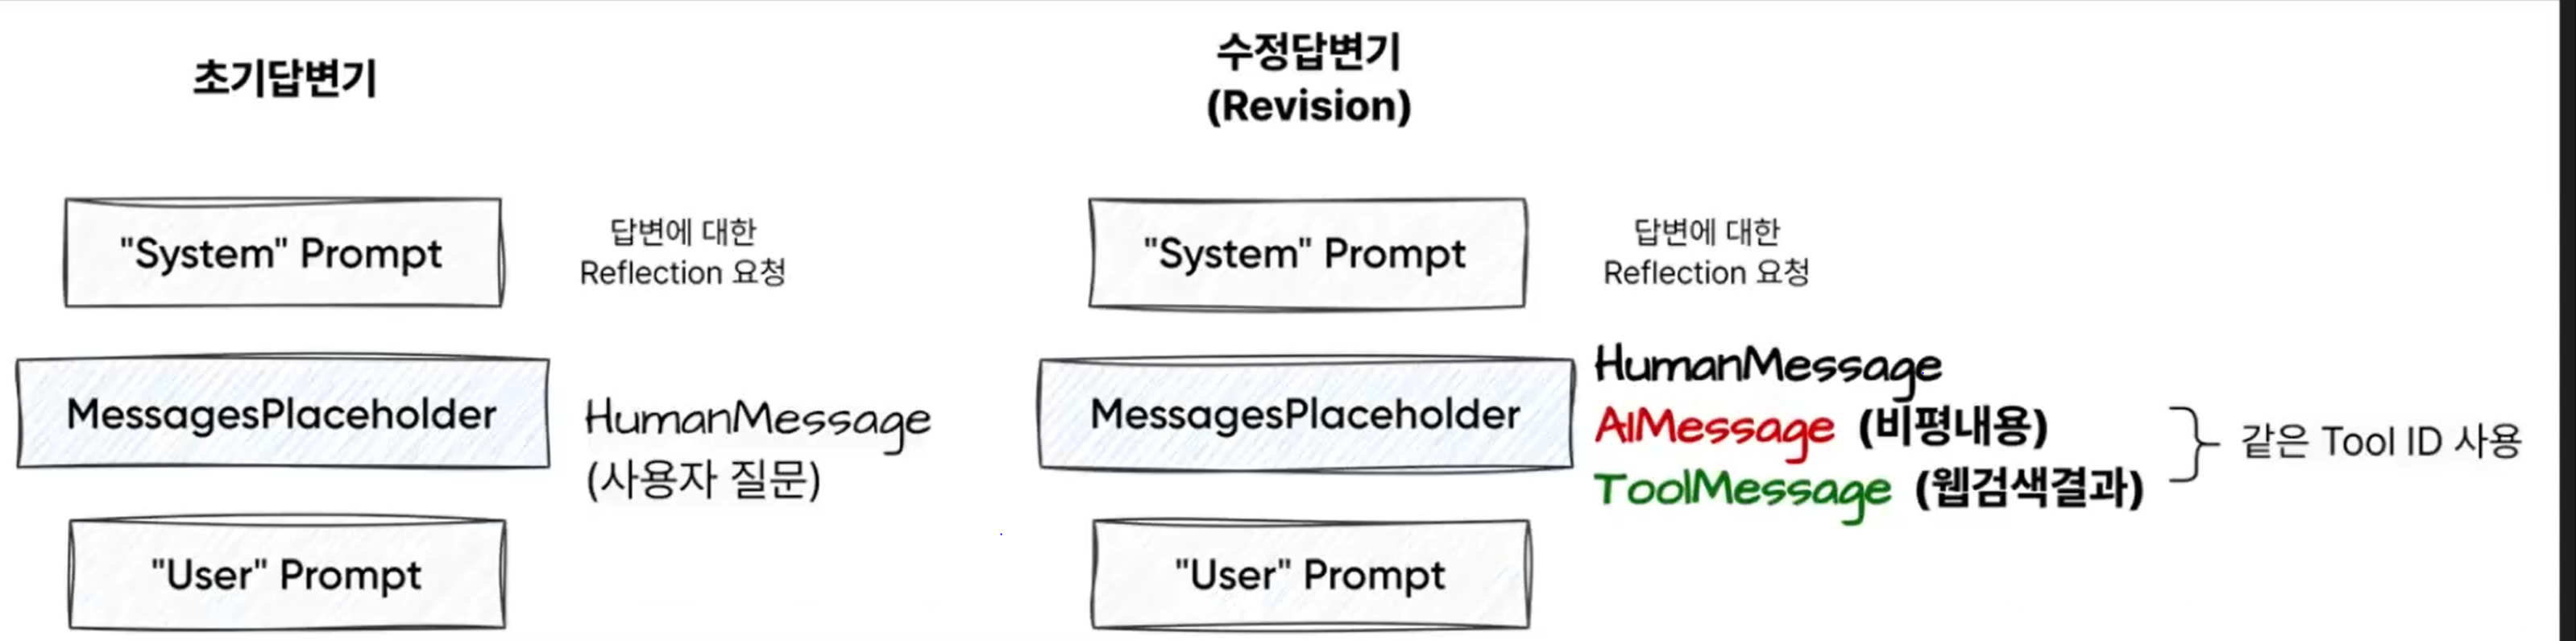

In [ ]:
revised["messages"]

In [ ]:
revised["messages"].tool_calls

## Step4. 웹검색을 위한 툴 노드 생성

In [ ]:
# search와 다르게 여러게의 입력이 들어오면 병렬처리하여 응답해주는 batch 사용

tavily_tool.batch(
    [
        {"query": initial["messages"].tool_calls[0]["args"]["search_queries"][0]}
    ]
)

`StructuredTool` `from_function`: 주어진 함수로부터 도구를 생성

```python
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b
tool = StructuredTool.from_function(add)
tool.run(1, 2)  # 3 리턴
```

In [ ]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])

tool_node = ToolNode(
    # 두가지 스키마가 name으로 들어간 이유는 웹검색 들어가기 이전의 노드는 
    # 초기 답변(AnswerQuestion 리턴) or n번째 답변(ReviseAnswer 리턴)한 노드가 될 것이다
    # 그래서 어떤 노드에서 호출하더라도 tavily_tool.batch를 호출 할수있도록 함
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__)
    ]
)

## Step 5. 그래프 생성하기

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
MAX_ITERATIONS = 5
graph_builder = StateGraph(State)
graph_builder.add_node("draft", first_responder.respond)

graph_builder.add_node("execute_tools", tool_node)  # 웹 검색 진행
graph_builder.add_node("revise", revisor.respond)

graph_builder.add_edge("draft", "execute_tools")
graph_builder.add_edge("execute_tools", "revise")

In [ ]:
# 조건부 엣지에 event_loop 추가

def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i

# revise node에 들어갈 때 MAX_ITERATION에 도달 할 때까지 반복해서 수정하도록 함
def event_loop(state: list):
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

graph_builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
graph_builder.add_edge(START, "draft")
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

# 초기 draft node의 초기 답변엔 3가지가 포함됨(답변, reflction 내용, 웹 검새을 위한 쿼리) 데이터 스키마인 AnswerQuestion이 Tool로써 감지되게 됨 
# 웹 검색을 위한 쿼리를 execute_tools에서 사용하여 웹검색 진행
# revise 노드에서 출처와 함께 검색 내용을 기반으로 새롭게 내용 작성
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
events = graph.stream(
    {"messages": [HumanMessage(content="AI Agent가 무엇인가요?")]},
    stream_mode="values"
)
for i, step in enumerate(events):
    print(f"step {i}")
    step["messages"][-1].pretty_print()